<a href="https://www.kaggle.com/code/hkafrawi/understanding-usd-price-through-gold?scriptVersionId=140562702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/gold-price-egp-telegram-channel-scrapped/export.csv')

# Explore the Data

In [3]:
df.head()

,text,date
0,بسم لله... جمعة مباركة 🤲 ...اللهم صلِّ صلاةً ك...,2021-01-01 08:57:49+00:00
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00
2,بسم لله... صباحكم كله رزق أن شآء الله ♥,2021-01-02 09:29:27+00:00
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00
4,بسم لله... صباحكم كله رزق أن شآء الله ♥,2021-01-03 09:49:52+00:00


In [4]:
df.iloc[1,0]

'☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨          ٧٠٩ جنيه \n⬅️عيار ٢١          ٨٢٧ جنيه \n⬅️عيار ٢٤         ٩٤٥ جنيه'

In [5]:
df.iloc[2,0]

'بسم لله... صباحكم كله رزق أن شآء الله ♥'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8806 entries, 0 to 8805
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8586 non-null   object
 1   date    8806 non-null   object
dtypes: object(2)
memory usage: 137.7+ KB


In [7]:
df[df['text'].isnull()]

,text,date
1191,NaN,2021-04-12 21:14:53+00:00
1409,NaN,2021-05-12 16:36:46+00:00
1937,NaN,2021-07-18 17:29:12+00:00
1945,NaN,2021-07-20 02:31:07+00:00
2078,NaN,2021-08-08 21:40:40+00:00
...,...,...
8588,NaN,2023-06-27 08:50:23+00:00
8589,NaN,2023-06-27 09:02:09+00:00
8693,NaN,2023-07-21 08:29:42+00:00
8703,NaN,2023-07-22 20:28:05+00:00


In [8]:
df[df['text'].isnull()].index

Int64Index([1191, 1409, 1937, 1945, 2078, 2684, 2867, 2943, 3010, 3048,
            ...
            8381, 8435, 8449, 8545, 8587, 8588, 8589, 8693, 8703, 8729],
           dtype='int64', length=220)

In [9]:
df.iloc[8000,0]

'☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0 ١٨٥١\xa0 جنيه \n⬅️عيار ٢١\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0 ٢١٦٠\xa0 جنيه \n⬅️عيار ٢٤\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0 ٢٤٦٩ \xa0 جنيه\n⬅️ الجنيه ذهب \xa0 ١٧٢٨٠\xa0 جنيه \n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0\xa0\xa0 ➖➖➖ ➖➖➖\nالأسعار لا تشمل المصنعيه\xa0 \n\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 ➖➖➖ ➖➖➖\nسعر الذهب العالمي💲\xa0 \n٢٠٠٨ دولار للأونصه'

In [10]:
df.iloc[1,0]

'☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨          ٧٠٩ جنيه \n⬅️عيار ٢١          ٨٢٧ جنيه \n⬅️عيار ٢٤         ٩٤٥ جنيه'

* There are null text rows that need to be elimintated
* Not all text rows contain information about gold price
* the format of the message changed since inception and carry more information


# Clean and Prepare the Dataset

In [11]:
dfv2 = df.drop(df[df['text'].isnull()].index,axis=0)

In [12]:
dfv2.iloc[0,0].find("\n")

-1

In [13]:
dfv2.iloc[0,0]

'بسم لله... جمعة مباركة 🤲 ...اللهم صلِّ صلاةً كاملةً، وسلّم سلامًا تامًّا على سيدنا محمد ♥'

In [14]:
dfv2.iloc[8000,0].find("\n")

19

In [15]:
dfv3 = dfv2[dfv2['text'].str.contains("\n")]

In [16]:
dfv4 = dfv3[~dfv3['text'].str.contains("الله")]

In [17]:
dfv4.reset_index(inplace=True)

In [18]:
dfv4.drop('index',axis=1,inplace=True)

/tmp/ipykernel_20/302208537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4.drop('index',axis=1,inplace=True)


In [19]:
dfv4.head()

,text,date
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00


In [20]:
dfv4['text_list'] = dfv4['text'].apply(lambda x:x.split("\n"))

/tmp/ipykernel_20/3287723382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4['text_list'] = dfv4['text'].apply(lambda x:x.split("\n"))


In [21]:
dfv4.head()

,text,date,text_list
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩..."
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩..."
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩..."
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠..."
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩..."


In [22]:
def get_price(regex:str, expressions:list,end:bool = True):
    if end:
        for expression in expressions:
            if x := re.search(regex,expression):
                return expression[x.end()+1:].strip()
    else:
        for expression in expressions:
            if x := re.search(regex,expression):
                return expression[:x.start()].strip()

In [23]:
dfv4['g 18k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ١٨',expressions))
dfv4['g 21k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ٢١',expressions))
dfv4['g 24k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ٢٤',expressions))
dfv4['Gold Coin EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('الجنيه ذهب',expressions))
dfv4['Oz 24k USD'] = dfv4['text_list'].apply(lambda expressions:get_price('دولار',expressions,end=False))

/tmp/ipykernel_20/3550805074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4['g 18k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ١٨',expressions))
/tmp/ipykernel_20/3550805074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4['g 21k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ٢١',expressions))
/tmp/ipykernel_20/3550805074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [24]:
dfv4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           7340 non-null   object
 1   date           7340 non-null   object
 2   text_list      7340 non-null   object
 3   g 18k EGP      6916 non-null   object
 4   g 21k EGP      6919 non-null   object
 5   g 24k EGP      6916 non-null   object
 6   Gold Coin EGP  1772 non-null   object
 7   Oz 24k USD     2932 non-null   object
dtypes: object(8)
memory usage: 458.9+ KB


In [25]:
dfv4.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠ جنيه,٨٤٠ جنيه,٩٦٠ جنيه,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩ جنيه,٨٣٩ جنيه,٩٥٩ جنيه,None,None


In [26]:
dfv4[dfv4['g 18k EGP'].isnull()]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
944,☆أسِـعٌأّر أّلَذهّـبً أّلَآنِ🇪🇬\n\n⬅️عٌيِّأّر ...,2021-03-23 08:45:03+00:00,"[☆أسِـعٌأّر أّلَذهّـبً أّلَآنِ🇪🇬, , ⬅️عٌيِّأّر...",None,None,None,None,None
1078,للإعلان على القناة 👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻\n\n@G...,2021-04-11 15:26:28+00:00,"[للإعلان على القناة 👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻, , @...",None,None,None,None,None
1087,🌙♥️ ‌‏﮼كل‏﮼سنه‏﮼وانتم ‏﮼بألف ‏﮼خير \n ...,2021-04-12 21:37:29+00:00,"[🌙♥️ ‌‏﮼كل‏﮼سنه‏﮼وانتم ‏﮼بألف ‏﮼خير , ...",None,None,None,None,None
1096,قناة اسعار الذهب لحظه بلحظه \nنتمنى لكم صوما م...,2021-04-13 16:22:51+00:00,"[قناة اسعار الذهب لحظه بلحظه , نتمنى لكم صوما ...",None,None,None,None,None
1106,قناة اسعار الذهب لحظه بلحظه \nنتمنى لكم صوما م...,2021-04-14 16:21:28+00:00,"[قناة اسعار الذهب لحظه بلحظه , نتمنى لكم صوما ...",None,None,None,None,None
...,...,...,...,...,...,...,...,...
7274,📣عرض اليوم🔥\nعلى سبيكه نص كيلو \n📌 بدون مصنعية...,2023-07-26 11:34:57+00:00,"[📣عرض اليوم🔥, على سبيكه نص كيلو , 📌 بدون مصنعي...",None,None,None,None,None
7275,⭐️⭐️العرض انتهى\nمبروك للمشترى ⭐️⭐️⭐️,2023-07-26 15:09:32+00:00,"[⭐️⭐️العرض انتهى, مبروك للمشترى ⭐️⭐️⭐️]",None,None,None,None,None
7276,**🔵صدر الآن، قرار الفائدة الصادر عن البنك الفي...,2023-07-26 18:01:22+00:00,[**🔵صدر الآن، قرار الفائدة الصادر عن البنك الف...,None,None,None,None,None
7295,⚡️عشان يظهر لك عروض كل يوم لازم تكون مسجل ال...,2023-08-01 19:51:55+00:00,[⚡️عشان يظهر لك عروض كل يوم لازم تكون مسجل ا...,None,None,None,None,None


In [27]:
dfv5 = dfv4.drop(dfv4[dfv4['g 18k EGP'].isnull()].index,axis=0)

In [28]:
dfv5.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠ جنيه,٨٤٠ جنيه,٩٦٠ جنيه,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩ جنيه,٨٣٩ جنيه,٩٥٩ جنيه,None,None


In [29]:
dfv5[dfv5['Oz 24k USD'].isnull()]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠ جنيه,٨٤٠ جنيه,٩٦٠ جنيه,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩ جنيه,٨٣٩ جنيه,٩٥٩ جنيه,None,None
...,...,...,...,...,...,...,...,...
4020,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩٢...,2022-04-18 10:15:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩٢ جنيه,١٠٤١ جنيه,١١٨٩ جنيه,None,None
4021,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩١...,2022-04-18 10:27:08+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩١ جنيه,١٠٤٠ جنيه,١١٨٨ جنيه,None,None
4023,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩٢...,2022-04-18 11:12:43+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩٢ جنيه,١٠٤١ جنيه,١١٨٩ جنيه,None,None
4024,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩٣...,2022-04-18 11:34:29+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩٣ جنيه,١٠٤٢ جنيه,١١٩٠ جنيه,None,None


In [30]:
dfv5['g 18k EGP'] = dfv5['g 18k EGP'].apply(lambda x:x.replace('جنيه','').strip())
dfv5['g 21k EGP'] = dfv5['g 21k EGP'].apply(lambda x:x.replace('جنيه','').strip())
dfv5['g 24k EGP'] = dfv5['g 24k EGP'].apply(lambda x:x.replace('جنيه','').strip())
dfv5['g 24k EGP'] = dfv5['g 24k EGP'].apply(lambda x:x.replace('جني',''))

In [31]:
dfv5['Gold Coin EGP'] = dfv5['Gold Coin EGP'].apply(lambda x: x.replace('جنيه','').strip() if type(x) is str else x)

In [32]:
dfv5.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠,٨٤٠,٩٦٠,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩,٨٣٩,٩٥٩,None,None


In [33]:
float(dfv5['g 18k EGP'][0])

709.0

In [34]:
dfv5[dfv5['g 18k EGP'].str.contains("/")].index

Int64Index([2529], dtype='int64')

In [35]:
dfv6 = dfv5.drop(dfv5[dfv5['g 18k EGP'].str.contains("/")].index, axis =0)

In [36]:
dfv6.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠,٨٤٠,٩٦٠,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩,٨٣٩,٩٥٩,None,None


In [37]:
dfv6['g 18k EGP'] = dfv6['g 18k EGP'].apply(lambda x:float(x))
dfv6['g 21k EGP'] = dfv6['g 21k EGP'].apply(lambda x:float(x))
dfv6['g 24k EGP'] = dfv6['g 24k EGP'].apply(lambda x:float(x))

In [38]:
dfv6[(~dfv6['Oz 24k USD'].isnull())&(dfv6['Oz 24k USD'].str.contains('و'))]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
7019,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٢٠...,2023-05-27 12:40:56+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٢...",2024.0,2360.0,2697.0,١٨٨٨٠,١٩٤٦و
7021,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٢٠...,2023-05-27 17:21:43+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٢...",2024.0,2360.0,2697.0,١٨٨٨٠,١٩٤٦و
7022,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٢٠...,2023-05-28 10:23:43+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٢...",2024.0,2360.0,2697.0,١٨٨٨٠,١٩٤٦و


In [39]:
dfv6[(~dfv6['Oz 24k USD'].isnull())&(dfv6['Oz 24k USD'].str.contains('الذهب'))]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
7288,⭐️⭐️☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ...,2023-07-29 09:47:45+00:00,"[⭐️⭐️☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ...",1848.0,2155.0,2463.0,١٧٢٤٠,سعر الذهب العالمي💲 ١٩٥٩


In [40]:
dfv6.loc[7019,'Oz 24k USD'] = 1946
dfv6.loc[7021,'Oz 24k USD'] = 1946
dfv6.loc[7022,'Oz 24k USD'] = 1946
dfv6.loc[7288,'Oz 24k USD'] = 1959

In [41]:
dfv6 = dfv6.fillna(np.nan)

In [42]:
dfv6['Gold Coin EGP'] = dfv6['Gold Coin EGP'].apply(lambda x:float(x))
dfv6['Oz 24k USD'] = dfv6['Oz 24k USD'].apply(lambda x:float(x))

In [43]:
dfv6.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",709.0,827.0,945.0,NaN,NaN
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",709.0,827.0,945.0,NaN,NaN
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",709.0,827.0,945.0,NaN,NaN
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",720.0,840.0,960.0,NaN,NaN
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",719.0,839.0,959.0,NaN,NaN


In [44]:
dfv6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6915 entries, 0 to 7339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           6915 non-null   object 
 1   date           6915 non-null   object 
 2   text_list      6915 non-null   object 
 3   g 18k EGP      6915 non-null   float64
 4   g 21k EGP      6915 non-null   float64
 5   g 24k EGP      6915 non-null   float64
 6   Gold Coin EGP  1772 non-null   float64
 7   Oz 24k USD     2920 non-null   float64
dtypes: float64(5), object(3)
memory usage: 744.2+ KB


In [45]:
dfv7 = dfv6.drop(['text','text_list'],axis=1)

In [46]:
dfv7.head()

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,2021-01-01 08:58:10+00:00,709.0,827.0,945.0,NaN,NaN
1,2021-01-02 09:29:35+00:00,709.0,827.0,945.0,NaN,NaN
2,2021-01-03 09:50:01+00:00,709.0,827.0,945.0,NaN,NaN
3,2021-01-04 09:16:55+00:00,720.0,840.0,960.0,NaN,NaN
4,2021-01-04 10:31:18+00:00,719.0,839.0,959.0,NaN,NaN


In [47]:
#convert USD Gold ounce to USD Gold grams
dfv7['g 24k USD'] = dfv7['Oz 24k USD']/28.3495

In [48]:
dfv7.head()

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD
0,2021-01-01 08:58:10+00:00,709.0,827.0,945.0,NaN,NaN,NaN
1,2021-01-02 09:29:35+00:00,709.0,827.0,945.0,NaN,NaN,NaN
2,2021-01-03 09:50:01+00:00,709.0,827.0,945.0,NaN,NaN,NaN
3,2021-01-04 09:16:55+00:00,720.0,840.0,960.0,NaN,NaN,NaN
4,2021-01-04 10:31:18+00:00,719.0,839.0,959.0,NaN,NaN,NaN


# Data Analysis

## Conversion Rate as per Gold:

In [49]:
dfv7['USD/EGP Rate'] = dfv7['g 24k EGP']/dfv7['g 24k USD']

In [50]:
dfv7[dfv7['USD/EGP Rate'].notnull()]

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD,USD/EGP Rate
4025,2022-04-18 12:09:46+00:00,894.0,1043.0,1191.0,NaN,1993.0,70.301064,16.941422
4026,2022-04-18 12:29:48+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069
4027,2022-04-18 12:35:45+00:00,897.0,1047.0,1196.0,NaN,1997.0,70.442159,16.978469
4028,2022-04-18 12:53:08+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069
4029,2022-04-18 13:44:19+00:00,897.0,1047.0,1196.0,NaN,1993.0,70.301064,17.012545
...,...,...,...,...,...,...,...,...
7335,2023-08-15 16:33:12+00:00,1920.0,2240.0,2560.0,17920.0,1904.0,67.161678,38.116975
7336,2023-08-15 17:52:23+00:00,1928.0,2250.0,2571.0,18000.0,1905.0,67.196952,38.260664
7337,2023-08-16 08:28:34+00:00,1924.0,2245.0,2566.0,17960.0,1905.0,67.196952,38.186256
7338,2023-08-16 09:39:35+00:00,1920.0,2240.0,2560.0,17920.0,1906.0,67.232226,38.076978


In [51]:
ex_rate = dfv7[dfv7['USD/EGP Rate'].notnull()]
ex_rate['date'] = pd.to_datetime(ex_rate['date'])
ex_rate = ex_rate.drop(ex_rate[ex_rate['USD/EGP Rate']<16].index,axis=0) #removing outliers due to incorrect parsing

/tmp/ipykernel_20/2484622494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_rate['date'] = pd.to_datetime(ex_rate['date'])


Text(0.1, 0.01, '**Red lines resemble estimated date of EGP devaluation')

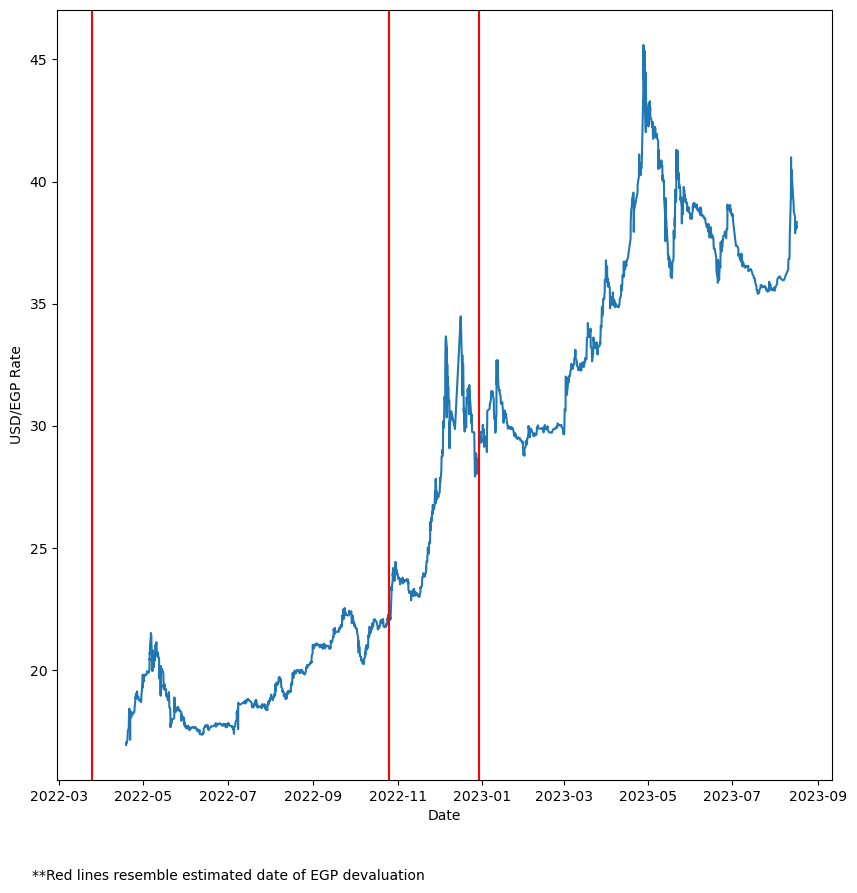

In [52]:
plt.figure(figsize=(10,10))
plt.plot_date(x=ex_rate[['date']],y=ex_rate[['USD/EGP Rate']],fmt='-')
plt.axvline(x=pd.to_datetime('2022-3-25'),color='red')
plt.axvline(x=pd.to_datetime('2022-10-26'),color='red')
plt.axvline(x=pd.to_datetime('2022-12-30'),color='red')
plt.xlabel('Date')
plt.ylabel('USD/EGP Rate')
plt.figtext(0.1,0.01,'**Red lines resemble estimated date of EGP devaluation')